# Import Libraries and Functions

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shany\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shany\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shany\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
class TextPreprocessor:
    def __init__(self, max_vocab_size=10000, max_seq_length=500):
        self.max_vocab_size = max_vocab_size
        self.max_seq_length = max_seq_length
        self.word2idx = {}
        self.idx2word = {}
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        
    def clean_text(self, text):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text
    
    def tokenize_lemmatize(self, text):
        tokens = word_tokenize(text)
        # Remove stopwords
        tokens = [token for token in tokens if token not in self.stop_words]
        # Lemmatize tokens
        lemmatized_tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        return lemmatized_tokens
    
    def build_vocabulary(self, texts):
        # Flatten all tokens
        all_tokens = []
        for text in texts:
            cleaned_text = self.clean_text(text)
            tokens = self.tokenize_lemmatize(cleaned_text)
            all_tokens.extend(tokens)
        
        # Get most common words
        word_counts = Counter(all_tokens)
        most_common = word_counts.most_common(self.max_vocab_size - 2)  # -2 for PAD and UNK
        
        # Create vocabulary
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        for word, _ in most_common:
            self.word2idx[word] = len(self.word2idx)
        
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
    
    def text_to_sequence(self, text):
        cleaned_text = self.clean_text(text)
        tokens = self.tokenize_lemmatize(cleaned_text)
        
        # Convert tokens to indices
        sequence = [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]
        
        # Pad or truncate sequence
        if len(sequence) < self.max_seq_length:
            sequence.extend([self.word2idx['<PAD>']] * (self.max_seq_length - len(sequence)))
        else:
            sequence = sequence[:self.max_seq_length]
        
        return sequence

In [4]:
class ResumeDataset(Dataset):
    def __init__(self, texts, labels, preprocessor):
        self.texts = texts
        self.labels = labels
        self.preprocessor = preprocessor
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        sequence = self.preprocessor.text_to_sequence(text)
        return torch.tensor(sequence), torch.tensor(label, dtype=torch.long)  # Convert label to Long type 

# Text Preprocessing (Don't run this if you already have pdf_ro_resume.csv)

In [66]:
import os
from pathlib import Path
import PyPDF2

def read_pdfs_to_dataframe(root_path):
    """
    Read all PDF files from folders and create a dataframe with occupation and resume columns.
    
    Args:
        root_path (str): Path to the root folder containing subfolders with PDF files or a single PDF file.
    
    Returns:
        pandas.DataFrame: DataFrame with columns ['occupation', 'resume']
    """
    pdf_data = []
    root_path = Path(root_path)

    # If input is a single PDF file
    if str(root_path).endswith('.pdf'):
        try:
            with open(root_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                text = ""
                for page in pdf_reader.pages:
                    text += page.extract_text() + "\n"

                # Split text into lines and filter out empty lines
                lines = [line.strip() for line in text.split('\n') if line.strip()]
                
                strip_category = os.path.basename(os.path.dirname(root_path))
                pdf_data.append({
                    'occupation': strip_category,
                    'resume': lines
                })
            print(f"Successfully processed: {root_path}")

        except Exception as e:
            print(f"Error reading {root_path}: {str(e)}")
            return pd.DataFrame()
        
    root_path = Path(root_path)
    
    # Find all PDF files recursively
    pdf_files = root_path.rglob("*.pdf")
    
    for pdf_file in pdf_files:
        strip_category = str(pdf_file).split('\\')[-2]  # Get the parent folder name as occupation

        try:
            with open(pdf_file, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                text = ""
                
                # Extract text from all pages
                for page_num in range(len(pdf_reader.pages)):
                    page = pdf_reader.pages[page_num]
                    text += page.extract_text() + "\n"

                # Split text into lines and filter out empty lines
                lines = [line.strip() for line in text.split('\n') if line.strip()]
                         
                pdf_data.append({
                    'occupation': strip_category,
                    'resume': lines
                })
                
                print(f"Successfully processed: {pdf_file}")
                
        except Exception as e:
            print(f"Error reading {pdf_file}: {str(e)}")
            pdf_data.append({
                'occupation': "",
                'resume': ""
            })
    
    # Create DataFrame
    pdf_df = pd.DataFrame(pdf_data)
    return pdf_df

In [67]:
data_df = read_pdfs_to_dataframe("dataset/data")

Successfully processed: dataset\data\ACCOUNTANT\10554236.pdf
Successfully processed: dataset\data\ACCOUNTANT\10674770.pdf
Successfully processed: dataset\data\ACCOUNTANT\11163645.pdf
Successfully processed: dataset\data\ACCOUNTANT\11759079.pdf
Successfully processed: dataset\data\ACCOUNTANT\12065211.pdf
Successfully processed: dataset\data\ACCOUNTANT\12202337.pdf
Successfully processed: dataset\data\ACCOUNTANT\12338274.pdf
Successfully processed: dataset\data\ACCOUNTANT\12442909.pdf
Successfully processed: dataset\data\ACCOUNTANT\12780508.pdf
Successfully processed: dataset\data\ACCOUNTANT\12802330.pdf
Successfully processed: dataset\data\ACCOUNTANT\13072019.pdf
Successfully processed: dataset\data\ACCOUNTANT\13130984.pdf
Successfully processed: dataset\data\ACCOUNTANT\13294301.pdf
Successfully processed: dataset\data\ACCOUNTANT\13491889.pdf
Successfully processed: dataset\data\ACCOUNTANT\13701259.pdf
Successfully processed: dataset\data\ACCOUNTANT\14055988.pdf
Successfully processed: 

In [71]:
# Initialize the preprocessor
text_preprocessor = TextPreprocessor()

# Create a function to process text
def process_text(text):
    # Check if input is a list and convert to string
    if isinstance(text, list):
        text = ' '.join(text)

    cleaned_text = text_preprocessor.clean_text(text)
    tokens = text_preprocessor.tokenize_lemmatize(cleaned_text)
    return tokens

# Create new column with cleaned tokens
data_df['cleaned_tokens'] = data_df['resume'].apply(process_text)

# Convert the list of tokens into a string for each row
data_df['cleaned_tokens'] = data_df['cleaned_tokens'].apply(lambda x: ' '.join(x))

# Create new DataFrame with all columns including cleaned tokens
new_df = pd.DataFrame({
    'occupation': data_df['occupation'],
    'resume': data_df['resume'],
    'cleaned_tokens': data_df['cleaned_tokens']
})

# Save to CSV
new_df.to_csv('pdf_to_resume.csv', index=False)

# GRU Classifier

In [5]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, 
                         bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.gru(embedded)
        # Concatenate the final forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        
        return self.fc(self.dropout(hidden))

In [6]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [7]:
# Default number of epochs = 50
# Default patience for early stopping = 5

def train_model(model, train_loader, val_loader, criterion, optimizer, device, n_epochs=50):
    train_losses = []
    val_losses = []
    early_stopping = EarlyStopping(patience=5)
    
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f'Epoch: {epoch+1}')
        print(f'Training Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            model.load_state_dict(early_stopping.best_model)
            break
    
    return train_losses, val_losses

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    return all_preds, all_targets

In [8]:
# Load data
df = pd.read_csv('pdf_to_resume.csv')

# Initialize preprocessor
preprocessor = TextPreprocessor()
preprocessor.build_vocabulary(df['resume'].values)

In [9]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['occupation'])

X = df['resume'].values

# Split data into train, validation, and test sets (0.7 train, 0.15 val, 0.15 test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, labels, test_size=0.3, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [10]:
# Create datasets
train_dataset = ResumeDataset(X_train, y_train, preprocessor)
val_dataset = ResumeDataset(X_val, y_val, preprocessor)
test_dataset = ResumeDataset(X_test, y_test, preprocessor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [19]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUClassifier(
    vocab_size=len(preprocessor.word2idx),
    embedding_dim=100,
    hidden_dim=128,
    output_dim=len(label_encoder.classes_),
    n_layers=2,
    dropout=0.2
).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train model
train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, device
)

# Evaluate model
predictions, targets = evaluate_model(model, test_loader, device)
# Calculate and print accuracy
accuracy = np.mean(np.array(predictions) == np.array(targets))
print(f"\nAccuracy: {accuracy:.4f}")

Epoch: 1
Training Loss: 2.5869
Validation Loss: 1.6907
Epoch: 2
Training Loss: 1.3816
Validation Loss: 1.1755
Epoch: 3
Training Loss: 0.9945
Validation Loss: 1.0965
Epoch: 4
Training Loss: 0.7733
Validation Loss: 1.1056
Epoch: 5
Training Loss: 0.5978
Validation Loss: 1.1466
Epoch: 6
Training Loss: 0.4377
Validation Loss: 1.1398
Epoch: 7
Training Loss: 0.3421
Validation Loss: 1.2154
Epoch: 8
Training Loss: 0.2412
Validation Loss: 1.2597
Early stopping triggered

Accuracy: 0.6729


In [20]:
# Print classification report
print("\nClassification Report:")
print(classification_report(targets, predictions, target_names=label_encoder.classes_))


Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.89      1.00      0.94        17
              ADVOCATE       0.68      0.76      0.72        17
           AGRICULTURE       0.08      0.10      0.09        10
               APPAREL       0.38      0.21      0.27        14
                  ARTS       0.26      0.31      0.29        16
            AUTOMOBILE       0.00      0.00      0.00         5
              AVIATION       0.41      0.50      0.45        18
               BANKING       0.42      0.28      0.33        18
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.90      1.00      0.95        18
                  CHEF       0.92      0.65      0.76        17
          CONSTRUCTION       0.87      0.76      0.81        17
            CONSULTANT       0.82      1.00      0.90        18
              DESIGNER       0.94      1.00      0.97        16
         DIGITA

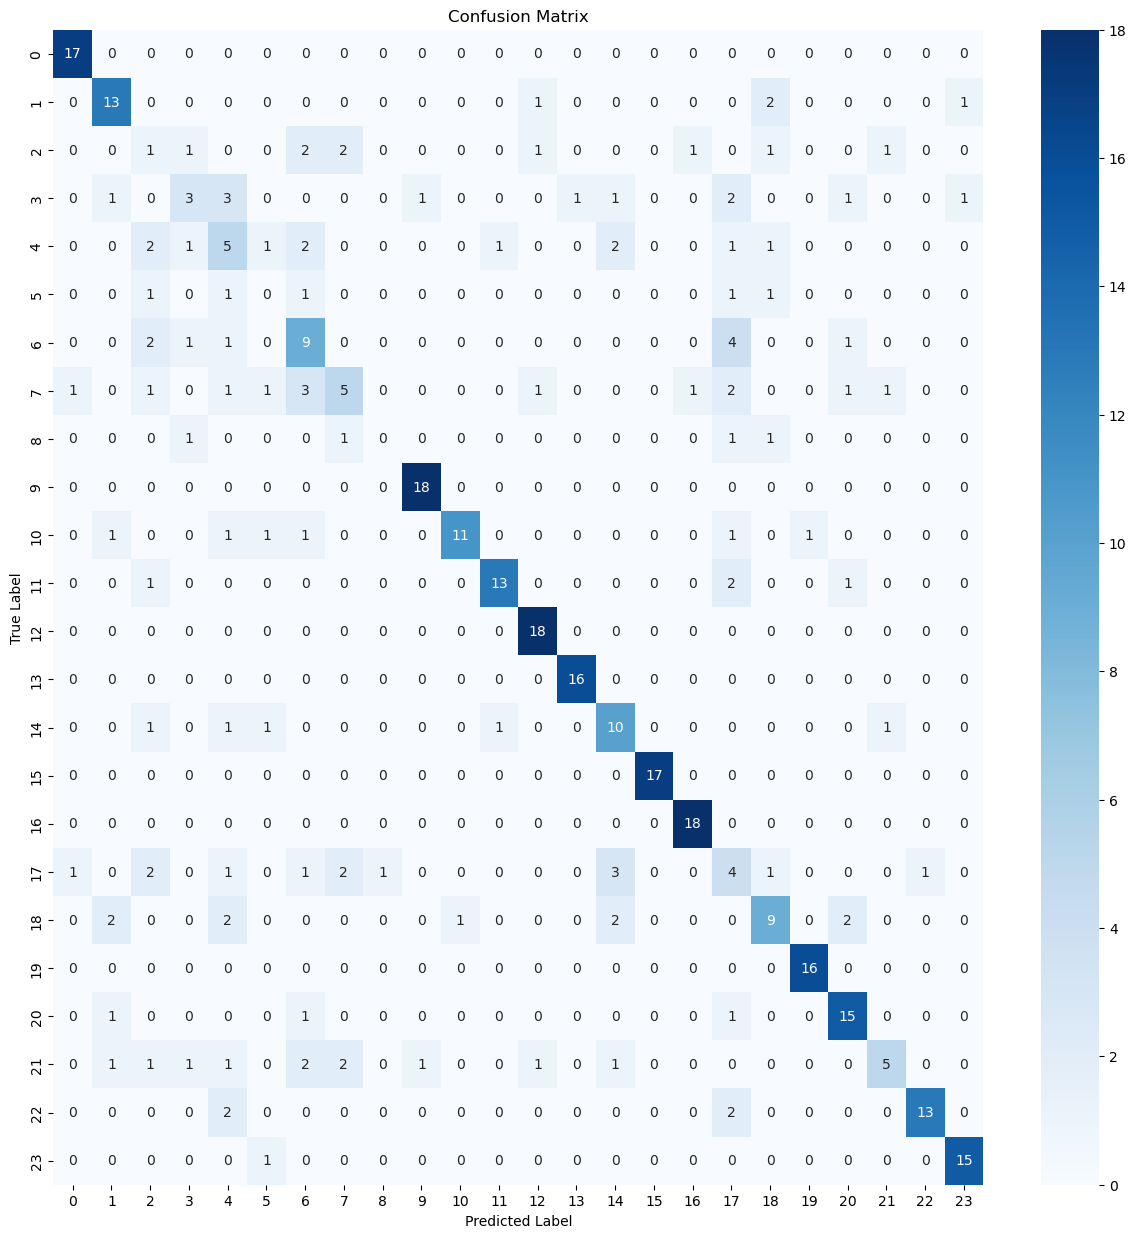

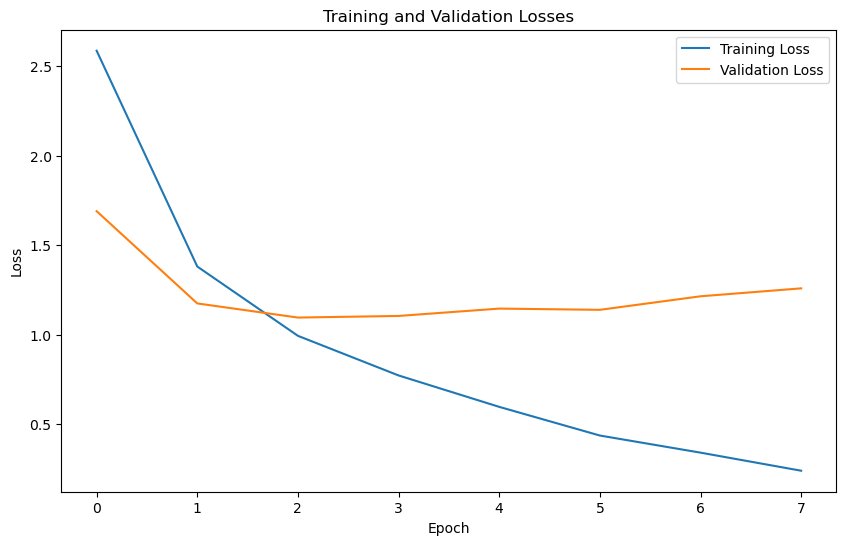

In [21]:
# Plot confusion matrix
cm = confusion_matrix(targets, predictions)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# LSTM Classifier

In [22]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                           bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))    
        output, (hidden, cell) = self.lstm(embedded)
        # Concatenate the final forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(self.dropout(hidden))

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = LSTMClassifier(
    vocab_size=len(preprocessor.word2idx),
    embedding_dim=100,
    hidden_dim=128,
    output_dim=len(label_encoder.classes_),
    n_layers=2,
    dropout=0.2
).to(device)

# Training setup
criterion_lstm = nn.CrossEntropyLoss()
optimizer_lstm = torch.optim.Adam(lstm_model.parameters())

# Train model
train_losses_lstm, val_losses_lstm = train_model(
    lstm_model, train_loader, val_loader, criterion_lstm, optimizer_lstm, device
)

# Evaluate model
predictions_lstm, targets_lstm = evaluate_model(lstm_model, test_loader, device)
print(f"\nAccuracy: {np.mean(np.array(predictions_lstm) == np.array(targets_lstm)):.4f}")

Epoch: 1
Training Loss: 2.7960
Validation Loss: 1.9346
Epoch: 2
Training Loss: 1.4790
Validation Loss: 1.2597
Epoch: 3
Training Loss: 1.0732
Validation Loss: 1.1612
Epoch: 4
Training Loss: 0.8929
Validation Loss: 1.1373
Epoch: 5
Training Loss: 0.7338
Validation Loss: 1.1702
Epoch: 6
Training Loss: 0.5874
Validation Loss: 1.1729
Epoch: 7
Training Loss: 0.4733
Validation Loss: 1.2546
Epoch: 8
Training Loss: 0.3739
Validation Loss: 1.2466
Epoch: 9
Training Loss: 0.2706
Validation Loss: 1.3259
Early stopping triggered

Accuracy: 0.6863


In [23]:
# Print classification report for the LSTM model
print("\nClassification Report for LSTM Model:")
print(classification_report(targets_lstm, predictions_lstm, target_names=label_encoder.classes_, zero_division=0))


Classification Report for LSTM Model:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.94      1.00      0.97        17
              ADVOCATE       0.82      0.82      0.82        17
           AGRICULTURE       0.08      0.10      0.09        10
               APPAREL       0.18      0.21      0.19        14
                  ARTS       0.28      0.31      0.29        16
            AUTOMOBILE       0.00      0.00      0.00         5
              AVIATION       0.33      0.44      0.38        18
               BANKING       0.23      0.17      0.19        18
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.90      1.00      0.95        18
                  CHEF       0.75      0.71      0.73        17
          CONSTRUCTION       0.82      0.82      0.82        17
            CONSULTANT       0.85      0.94      0.89        18
              DESIGNER       0.94      1.00      0.97        16


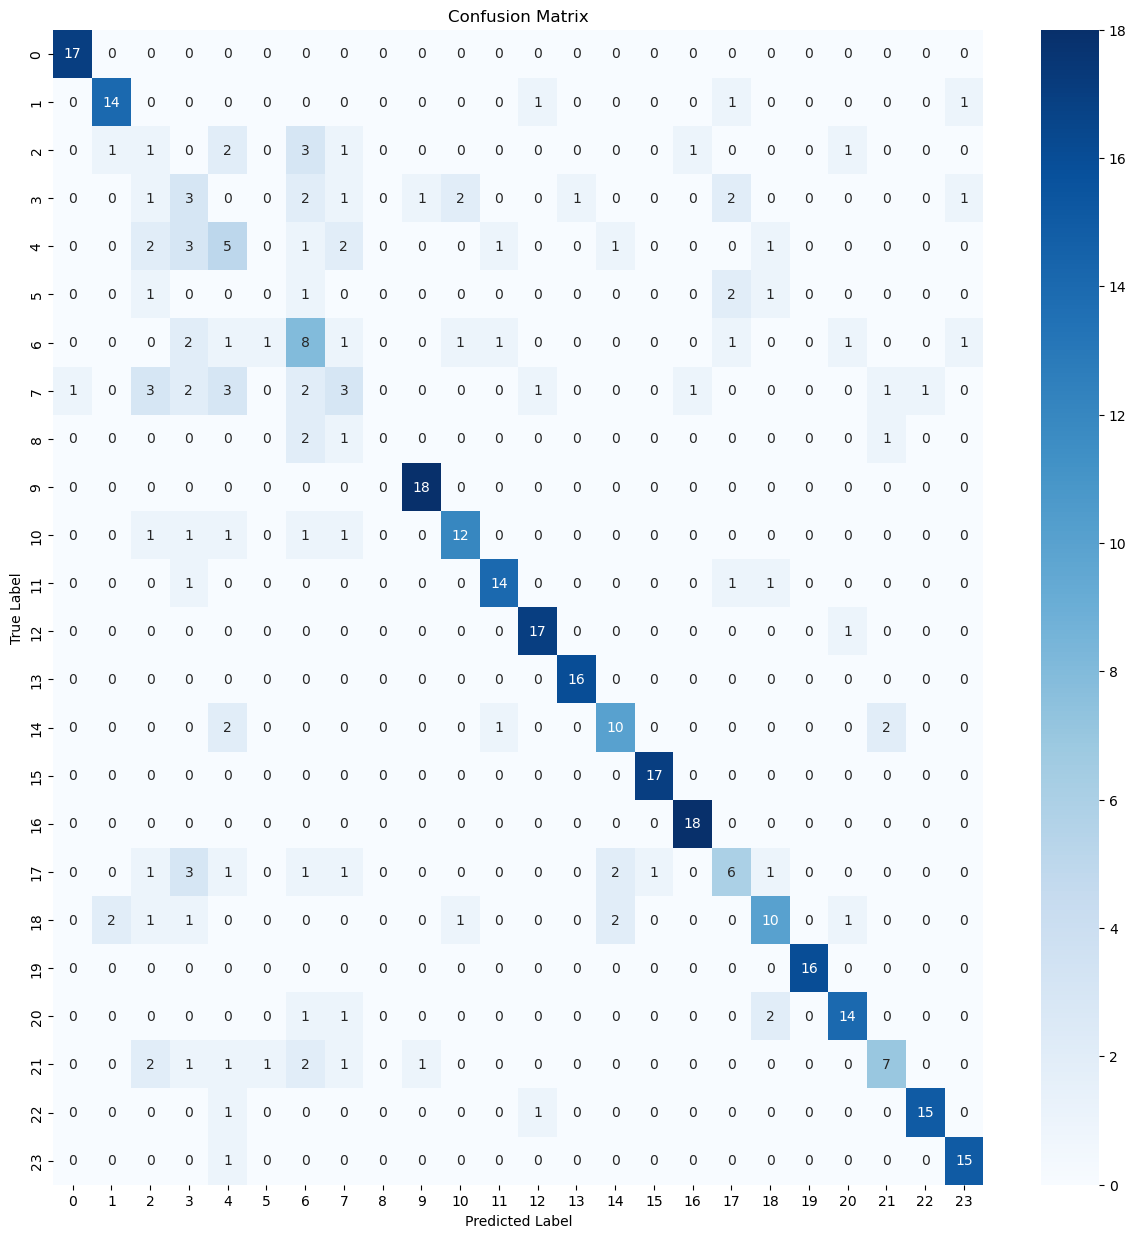

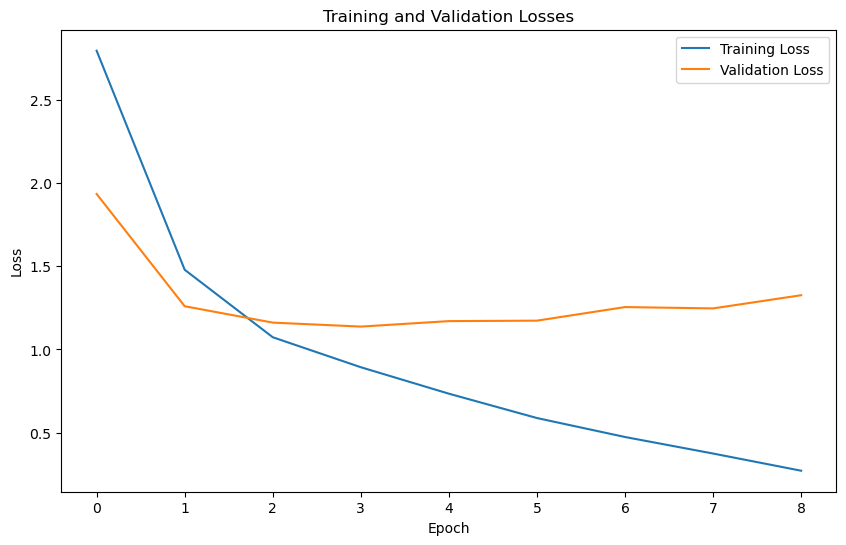

In [24]:
# Plot confusion matrix
cm = confusion_matrix(targets_lstm, predictions_lstm)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses_lstm, label='Training Loss')
plt.plot(val_losses_lstm, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# RNN Classifier

In [25]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers,
                         bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        # Concatenate the final forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(self.dropout(hidden))

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model = RNNClassifier(
    vocab_size=len(preprocessor.word2idx),
    embedding_dim=100,
    hidden_dim=128,
    output_dim=len(label_encoder.classes_),
    n_layers=2,
    dropout=0.2
).to(device)

# Training setup
criterion_rnn = nn.CrossEntropyLoss()
optimizer_rnn = torch.optim.Adam(rnn_model.parameters())

# Train model
train_losses_rnn, val_losses_rnn = train_model(
    rnn_model, train_loader, val_loader, criterion_rnn, optimizer_rnn, device
)

# Evaluate model
predictions_rnn, targets_rnn = evaluate_model(rnn_model, test_loader, device)
print(f"\nRNN Accuracy: {np.mean(np.array(predictions_rnn) == np.array(targets_rnn)):.4f}")

Epoch: 1
Training Loss: 2.5383
Validation Loss: 1.8723
Epoch: 2
Training Loss: 1.5806
Validation Loss: 1.4493
Epoch: 3
Training Loss: 1.2123
Validation Loss: 1.2914
Epoch: 4
Training Loss: 0.9652
Validation Loss: 1.2754
Epoch: 5
Training Loss: 0.7859
Validation Loss: 1.2543
Epoch: 6
Training Loss: 0.6281
Validation Loss: 1.3246
Epoch: 7
Training Loss: 0.5350
Validation Loss: 1.3686
Epoch: 8
Training Loss: 0.4383
Validation Loss: 1.4070
Epoch: 9
Training Loss: 0.3393
Validation Loss: 1.4269
Epoch: 10
Training Loss: 0.2900
Validation Loss: 1.4792
Early stopping triggered

RNN Accuracy: 0.6381


In [26]:
# Print classification report for the RNN model
print("\nRNN Classification Report:")
print(classification_report(targets_rnn, predictions_rnn, target_names=label_encoder.classes_, zero_division=0))


RNN Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.94      1.00      0.97        17
              ADVOCATE       0.57      0.76      0.65        17
           AGRICULTURE       0.00      0.00      0.00        10
               APPAREL       0.38      0.36      0.37        14
                  ARTS       0.22      0.25      0.24        16
            AUTOMOBILE       0.33      0.20      0.25         5
              AVIATION       0.32      0.50      0.39        18
               BANKING       0.22      0.11      0.15        18
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.82      1.00      0.90        18
                  CHEF       0.79      0.65      0.71        17
          CONSTRUCTION       0.85      0.65      0.73        17
            CONSULTANT       0.90      1.00      0.95        18
              DESIGNER       0.79      0.94      0.86        16
         DI

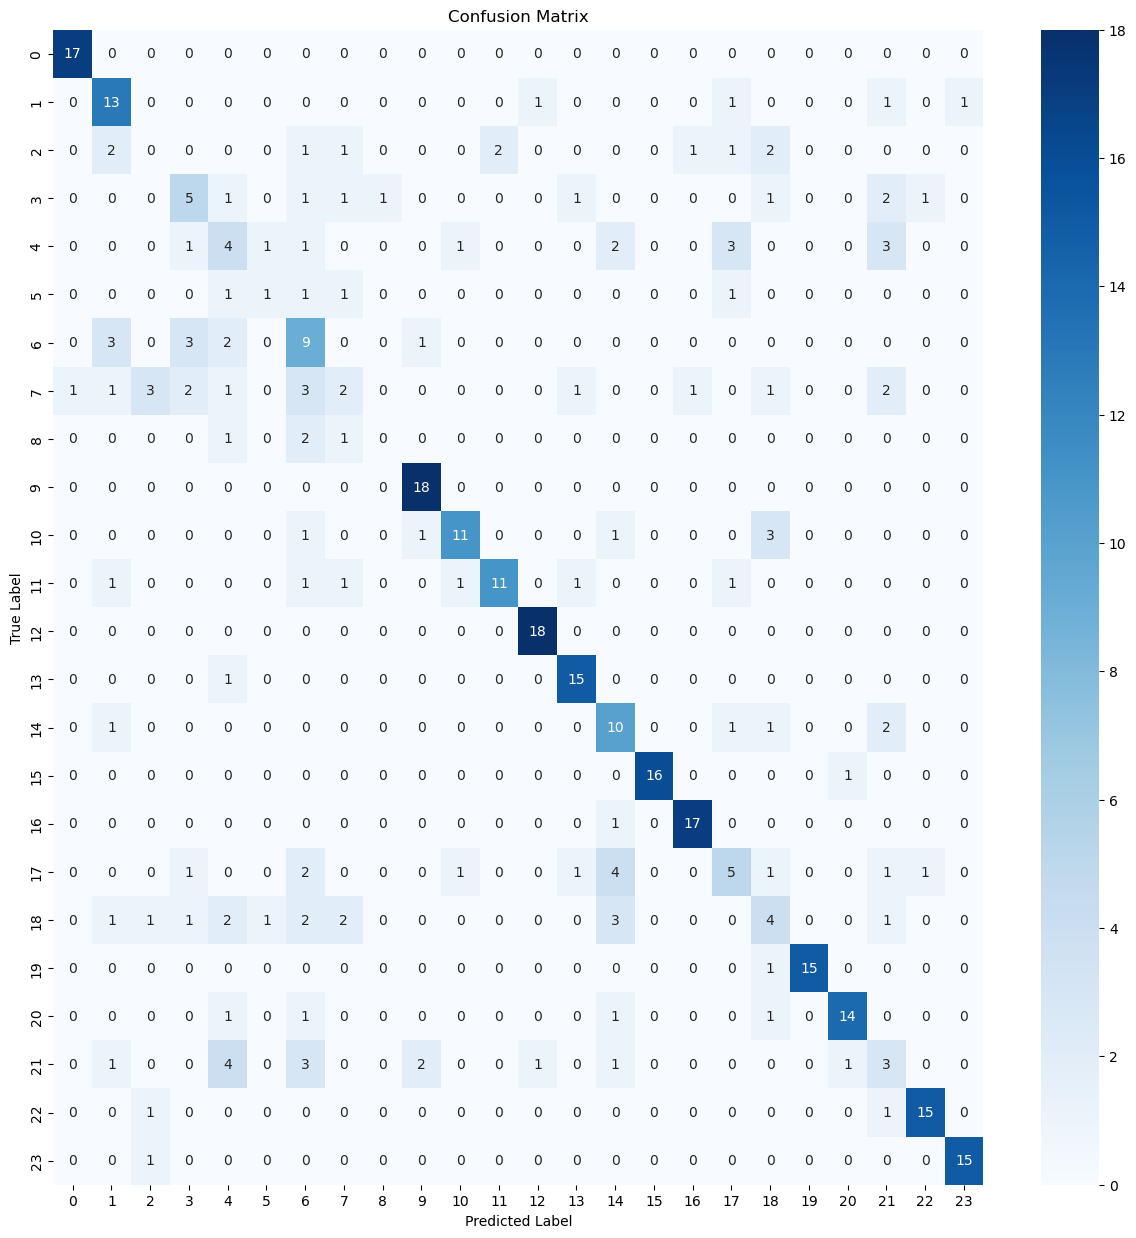

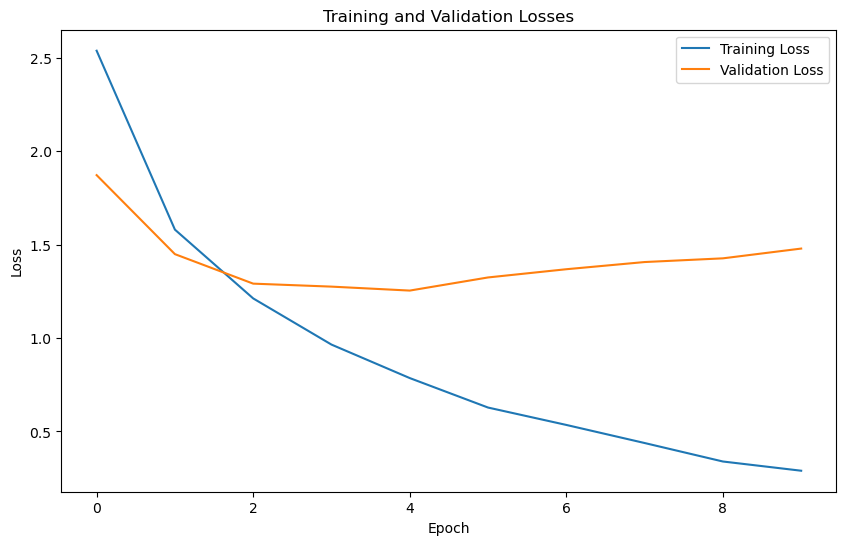

In [27]:
# Plot confusion matrix
cm = confusion_matrix(targets_rnn, predictions_rnn)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses_rnn, label='Training Loss')
plt.plot(val_losses_rnn, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testing

In [36]:
sample = "Detail-oriented accountant with expertise in financial reporting, tax compliance, and cost optimization. Skilled in analyzing financial data to enhance operational efficiency and ensure regulatory adherence. Proficient in bookkeeping, budget forecasting, and auditing. Adept at using accounting software to streamline workflows and improve accuracy"

def predict_occupation(sample_text, model, preprocessor, label_encoder, device):
    model.eval()
    sequence = preprocessor.text_to_sequence(sample_text)
    sequence_tensor = torch.tensor(sequence).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        output = model(sequence_tensor)
        prediction = output.argmax(dim=1).item()
    return label_encoder.inverse_transform([prediction])[0]

predicted_occupation = predict_occupation(sample, lstm_model, preprocessor, label_encoder, device)
print(f"Predicted Occupation: {predicted_occupation}")

Predicted Occupation: ACCOUNTANT


# Saving the Model

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'gru_classifier.pth')
torch.save(lstm_model.state_dict(), 'lstm_classifier.pth')
torch.save(rnn_model.state_dict(), 'rnn_classifier.pth')

# Reset Model

In [ ]:
def reset_model_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
        elif isinstance(layer, nn.Sequential):
            for l in layer:
                if hasattr(l, 'reset_parameters'):
                    l.reset_parameters()

# Usage:
reset_model_weights(model)
reset_model_weights(lstm_model)
reset_model_weights(rnn_model)